In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from datetime import datetime
from scipy.io import loadmat
from sklearn.utils import shuffle

In [3]:
train = loadmat('./SVHN/train_32x32.mat')
test = loadmat('./SVHN/test_32x32.mat')

In [4]:
print(train['X'].shape)
print(train['y'].shape)

(32, 32, 3, 73257)
(73257, 1)


In [6]:
def rearange(X):
    # reshape and normalize
    return (X.transpose(3, 0, 1, 2)/255).astype(np.float32)

In [7]:
def one_hot(y):
    ind = np.zeros((len(y), len(set(y))))
    for i in range(len(y)):
        ind[i, y[i]] = 1
    return ind

In [9]:
Xtrain = rearange(train['X'])
Ytrain = one_hot(train['y'].flatten()-1)
Xtest = rearange(test['X'])
Ytest = one_hot(test['y'].flatten()-1)

In [10]:
print(Xtrain.shape)
print(Ytrain.shape)

(73257, 32, 32, 3)
(73257, 10)


In [12]:
max_iter = 20
print_period = 10
batch_sz = 500
n_batches = Xtrain.shape[0] // batch_sz

In [13]:
M1 = 512
M2 = 256
K = 10

In [14]:
# change input into tensor variable
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
Y = tf.placeholder(tf.int32, shape=(K), name='Y')

In [15]:
conv1 = tf.layers.conv2d(
      inputs=X,
      filters=20,
      kernel_size=[5, 5],
      padding="same",
      use_bias=True,
      kernel_initializer=tf.contrib.layers.xavier_initializer(),
      activation=tf.nn.relu)

In [16]:
conv1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(20)])

In [17]:
# Pooling Layer 1: reduces 28x28 to 16x16
pool1 = tf.layers.max_pooling2d(
    inputs=conv1, 
    pool_size=[2, 2], 
    strides=2)

In [18]:
pool1.shape

TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(20)])

In [19]:
# Convolutional Layer 2 and Pooling Layer 2: reduces 16x16 to 8x8
conv2 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  use_bias=True,
  kernel_initializer=tf.contrib.layers.xavier_initializer(),
  activation=tf.nn.relu)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2, 
    pool_size=[2, 2], 
    strides=2)

In [20]:
pool2.shape

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(64)])

In [21]:
# Dense Layer: we naow have 64, 8x8 filters we need to flatten
pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
dense1 = tf.layers.dense(
    inputs=pool2_flat, 
    units=512, 
    activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=0.4, training=False)

In [22]:
dense2 = tf.layers.dense(
    inputs=dropout1, 
    units=256, 
    activation=tf.nn.relu)
dropout2 = tf.layers.dropout(
  inputs=dense2, rate=0.4, training=False)

In [23]:
# Logits Layer
logits = tf.layers.dense(inputs=dropout2, units=10)

In [25]:
# Calculate Loss (for both TRAIN and EVAL modes)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=T, logits=logits))

In [26]:
# create optimizer
train_op = tf.train.RMSPropOptimizer(learning_rate = 0.001, decay=0.9, momentum=0.9, epsilon=1e-10).minimize(loss)

In [27]:
pred = tf.argmax(input=logits, axis=1)

In [28]:
def err_rate(p,t):
    return np.mean(p!=t)

In [30]:
LL = []
error = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(max_iter):
        Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
        for j in range(n_batches):
            Xbatch = Xtrain[(j*batch_sz):(j*batch_sz + batch_sz), :]
            Ybatch = Ytrain[(j*batch_sz):(j*batch_sz + batch_sz), :]
            
            sess.run(train_op, feed_dict={X : Xbatch, T : Ybatch})
            if j % print_period == 0:
                loss_val = sess.run(loss, feed_dict={X : Xtest, T : Ytest})
                pred_val = sess.run(pred, feed_dict={X : Xtest})
                err = err_rate(pred_val, Ytest.argmax(axis=1))
                print(i,j,loss_val,err)
                LL.append(loss_val)
                error.append(err)

0 0 2.3120067 0.9131837738168408
0 10 2.2633324 0.8037031346035648
0 20 2.2378402 0.8042025199754149
0 30 2.2331119 0.8041256914566687
0 40 2.233218 0.8040488629379225
0 50 2.2305307 0.8041256914566687
0 60 2.2284353 0.8040872771972957
0 70 2.2233257 0.8040872771972957
0 80 2.2238874 0.7962891825445605
0 90 2.219307 0.8041256914566687
0 100 2.0721204 0.7441226183159189
0 110 2.181157 0.8040872771972957
0 120 2.098613 0.7155424093423479
0 130 1.248173 0.38137676705593115
0 140 1.0342585 0.3248309772587584
1 0 0.9683458 0.30554701905347265
1 10 0.7774426 0.2273740012292563
1 20 0.7549901 0.22745082974800246
1 30 0.705377 0.20651505838967424
1 40 0.70539147 0.20651505838967424
1 50 0.616582 0.1884219422249539
1 60 0.608472 0.17908727719729564
1 70 0.5829313 0.1689459127228027
1 80 0.5806162 0.16606484326982177
1 90 0.57311743 0.1727105101413645
1 100 0.5739903 0.16621850030731408
1 110 0.5862109 0.1737861094038107
1 120 0.54305536 0.16068684695759067
1 130 0.5127952 0.1524661954517517
1 1

15 60 1.0892472 0.13291333743085434
15 70 0.8889789 0.1411724031960664
15 80 1.1871742 0.14770282728948986
15 90 0.86385256 0.12142747387830363
15 100 1.2699913 0.12995543945912721
15 110 0.80119884 0.13448832206515057
15 120 0.98613936 0.12334818684695759
15 130 0.9347451 0.12281038721573448
15 140 0.9477824 0.1309157959434542
16 0 1.0187942 0.15772894898586357
16 10 0.82518697 0.146319913952059
16 20 0.9958476 0.1236939151813153
16 30 0.9445276 0.13610172095881992
16 40 1.0266601 0.1218500307314075
16 50 1.0539024 0.12127381684081132
16 60 0.91997206 0.11919944683466503
16 70 1.0609062 0.1294176398279041
16 80 1.0172825 0.12822679778733867
16 90 1.0282156 0.14728027043638597
16 100 1.1452755 0.12423171481253842
16 110 0.88669276 0.13621696373693915
16 120 0.9005647 0.12304087277197295
16 130 0.9660103 0.12964812538414258
16 140 1.1480923 0.12542255685310388
17 0 1.075633 0.12626767055931162
17 10 0.9346946 0.13126152427781193
17 20 1.0115849 0.12768899815611556
17 30 1.0384635 0.1191

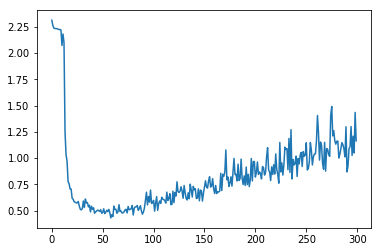

In [31]:
plt.plot(LL)
plt.show()

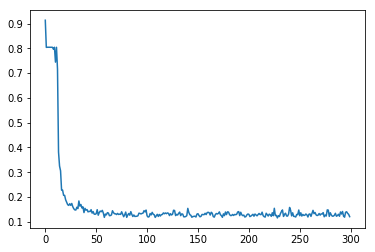

In [32]:
plt.plot(error)
plt.show()